In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install Levenshtein

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install livelossplot

In [74]:
import torch
import torchvision
import time
import importlib
import string
import os
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Levenshtein as lev
import load_data
from torchvision import models, transforms
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import F1Score
from tqdm import tqdm
from IPython import display
from livelossplot import PlotLosses

from load_data import RecognitionDataset, Resize

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"matthewiskornev","key":"d5924493559d2d1c944b7d51e1174652"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c vk-made-ocr
!unzip vk-made-ocr.zip -d ./

In [7]:
importlib.reload(load_data)

from load_data import RecognitionDataset, Resize, TestDataset

In [8]:
PATH_TO_DATA = "./"

In [9]:
config_path = os.path.join(PATH_TO_DATA, "train_labels.csv")
images_path = os.path.join(PATH_TO_DATA, "train/train")
assert os.path.isfile(config_path)
assert os.path.isdir(images_path)

In [10]:
df = pd.read_csv(config_path)

In [11]:
df.head()

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276000 entries, 0 to 275999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        276000 non-null  object
 1   Expected  275973 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


In [13]:
def calc_text_len(df):
    df_tmp = df.dropna().copy()
    len_text = []
    for row in df_tmp.iterrows():
        len_text.append(len(row[1]["Expected"]))
    df_tmp["len_text"] = len_text
    return df_tmp

In [14]:
df_2 = calc_text_len(df)

In [15]:
df_2.head()

,Id,Expected,len_text
0,1.jpg,Атырау,6
1,2.jpg,транз,5
2,3.jpg,ходят,5
3,4.jpg,"ощущений,",9
4,5.jpg,74,2


Посмотрим на распределение длин текстов:

<Axes: >

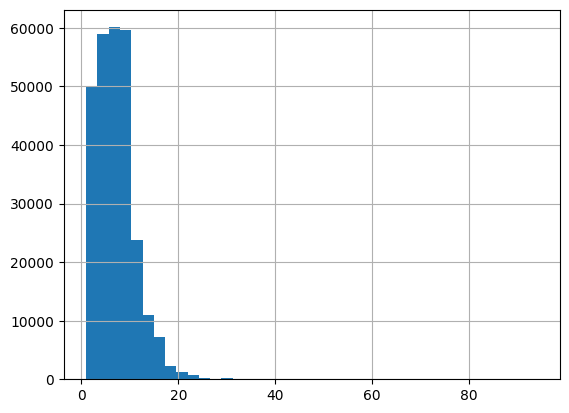

In [16]:
df_2["len_text"].hist(bins=40)

In [17]:
len(df_2[df_2["len_text"] > 25])

916

In [18]:
print(f"Доля записей, длина которых больше 25: {np.round(len(df_2[df_2['len_text'] > 25]) / len(df_2), 4)}")

Доля записей, длина которых больше 25: 0.0033


In [19]:
MAX_SEQ_LEN = 25

### 1. Сформируем алфавит

In [20]:
def get_alphabet(df):
    abc = set()
    for row in df.iterrows():
        for symbol in row[1]["Expected"]:
            abc.add(symbol)
    return list(abc)

Получим все уникальные символы:

In [21]:
abc = get_alphabet(df_2)

In [22]:
abc

['F',
 '観',
 'Ë',
 '9',
 '∼',
 '£',
 '1',
 'Q',
 'o',
 '吳',
 '、',
 'Ք',
 '─',
 'り',
 'Ь',
 '·',
 'ь',
 '。',
 'ք',
 '¡',
 '近',
 'ß',
 '費',
 '：',
 'j',
 'e',
 'S',
 'І',
 'm',
 '长',
 '军',
 'Ô',
 '意',
 'く',
 '董',
 '２',
 '；',
 'N',
 '☆',
 '追',
 'し',
 'か',
 '%',
 '）',
 'ὶ',
 '\\',
 'θ',
 'ι',
 ']',
 '‑',
 'τ',
 'ў',
 '秀',
 'Б',
 '∘',
 '็',
 '▪',
 'r',
 '會',
 '主',
 'ἄ',
 'Ⅱ',
 '１',
 '内',
 'و',
 'χ',
 '介',
 'V',
 'Ö',
 '８',
 '江',
 '−',
 'Ｎ',
 'ห',
 '琬',
 '＆',
 'ख',
 'я',
 'ト',
 'л',
 '”',
 '喫',
 'ō',
 'х',
 'X',
 'あ',
 '定',
 'α',
 'κ',
 'ら',
 'ひ',
 'қ',
 'の',
 '｜',
 '蘇',
 'b',
 'Є',
 'C',
 '▁',
 '始',
 '2',
 '中',
 'ㄞ',
 '+',
 'р',
 'T',
 '魚',
 'ü',
 '≡',
 'é',
 'Ｃ',
 ':',
 '田',
 '東',
 '\u200c',
 'ぶ',
 '刻',
 '王',
 'æ',
 'U',
 '=',
 '白',
 'さ',
 '桓',
 'È',
 '_',
 'Ο',
 'ξ',
 'R',
 'こ',
 'з',
 "'",
 'i',
 '場',
 '朝',
 'ุ',
 '﹣',
 'э',
 '９',
 '“',
 '½',
 ',',
 ';',
 'y',
 'Ι',
 'ळ',
 'ύ',
 '´',
 'Й',
 'ã',
 'w',
 '김',
 'ς',
 'Ν',
 '²',
 'る',
 '«',
 '승',
 '＇',
 'า',
 '三',
 '×',
 'ง',
 'ु',
 'W',
 '村'

Очень много странных и непонятных символов, попробуем от них избавиться:

In [23]:
DIGITS = "0123456789"
RUS_LETTERS = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
RUS_LETTERS += RUS_LETTERS.upper()

In [24]:
ACCEPTABLE_SYM = DIGITS + RUS_LETTERS + string.punctuation + string.ascii_letters + " "
len(ACCEPTABLE_SYM)

161

In [25]:
ACCEPTABLE_SYM

'0123456789абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '

In [26]:
def filter_data(df):
    df_tmp = df.copy()
    acc_flg = np.ones(len(df_tmp))
    for i, row in enumerate(df_tmp.iterrows()):
        for symbol in row[1]["Expected"]:
            if symbol not in ACCEPTABLE_SYM:
#                 acc_flg.append(None)
                acc_flg[i] = None
                break
#         acc_flg.append(1)
    df_tmp["acc_flg"] = acc_flg
    df_tmp.dropna(inplace=True)
    return df_tmp

In [27]:
df_filtered = filter_data(df_2)

In [34]:
print(f"Процент удаленных картинок = {np.round(100 - len(df_filtered) / len(df_2) * 100, 4)}%")

Процент удаленных картинок = 2.6147%


In [35]:
true_abc = ACCEPTABLE_SYM

### 2. Создаем датакласс

In [36]:
config = df_filtered.to_dict(orient='records')

config_full_paths = []
for item in config:
    config_full_paths.append({"file": os.path.join(images_path, item["Id"]),
                              "text": item["Expected"]})
config = config_full_paths

In [37]:
config

[{'file': './train/train/1.jpg', 'text': 'Атырау'},
 {'file': './train/train/2.jpg', 'text': 'транз'},
 {'file': './train/train/3.jpg', 'text': 'ходят'},
 {'file': './train/train/4.jpg', 'text': 'ощущений,'},
 {'file': './train/train/5.jpg', 'text': '74'},
 {'file': './train/train/6.jpg', 'text': 'странах'},
 {'file': './train/train/7.jpg', 'text': "CATTLEMEN'S"},
 {'file': './train/train/8.jpg', 'text': 'SF'},
 {'file': './train/train/9.jpg', 'text': 'НАТАЛЬЯ'},
 {'file': './train/train/11.jpg', 'text': 'ЦЕНТРАЛЬНОМ'},
 {'file': './train/train/12.jpg', 'text': 'боями'},
 {'file': './train/train/13.jpg', 'text': 'рой'},
 {'file': './train/train/14.jpg', 'text': 'FORNET'},
 {'file': './train/train/15.jpg', 'text': 'день'},
 {'file': './train/train/16.jpg', 'text': 'действуют'},
 {'file': './train/train/17.jpg', 'text': '15993628977'},
 {'file': './train/train/18.jpg', 'text': 'Организационные'},
 {'file': './train/train/19.jpg', 'text': 'Танковый'},
 {'file': './train/train/20.jpg', 'te

In [38]:
len(config)

268757

In [39]:
height = []
width = []
for elem in config:
    im_path = elem["file"]
    image = cv2.imread(im_path).astype(np.float32) / 255.
    height.append(image.shape[0])
    width.append(image.shape[1])

Посмотрим на распределение высот и длин картинок:

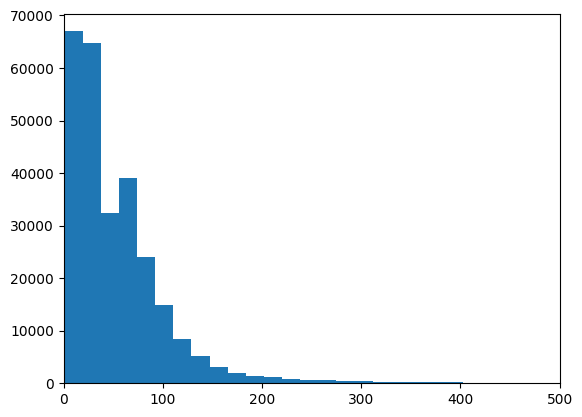

In [40]:
plt.hist(height, bins=100)
plt.xlim([0, 500])
plt.show()

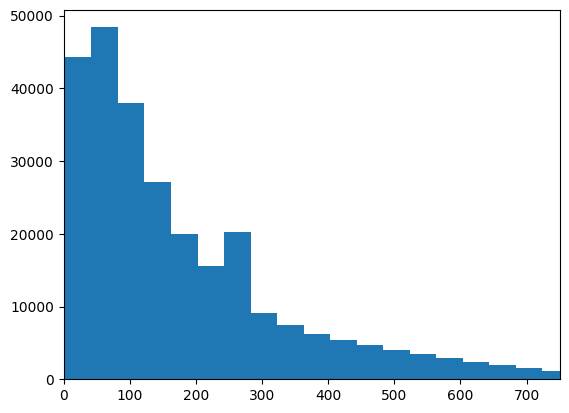

In [41]:
plt.hist(width, bins=100)
plt.xlim([0, 750])
plt.show()

In [42]:
np.mean(height)

56.37225449011561

In [43]:
np.mean(width)

191.51667119368054

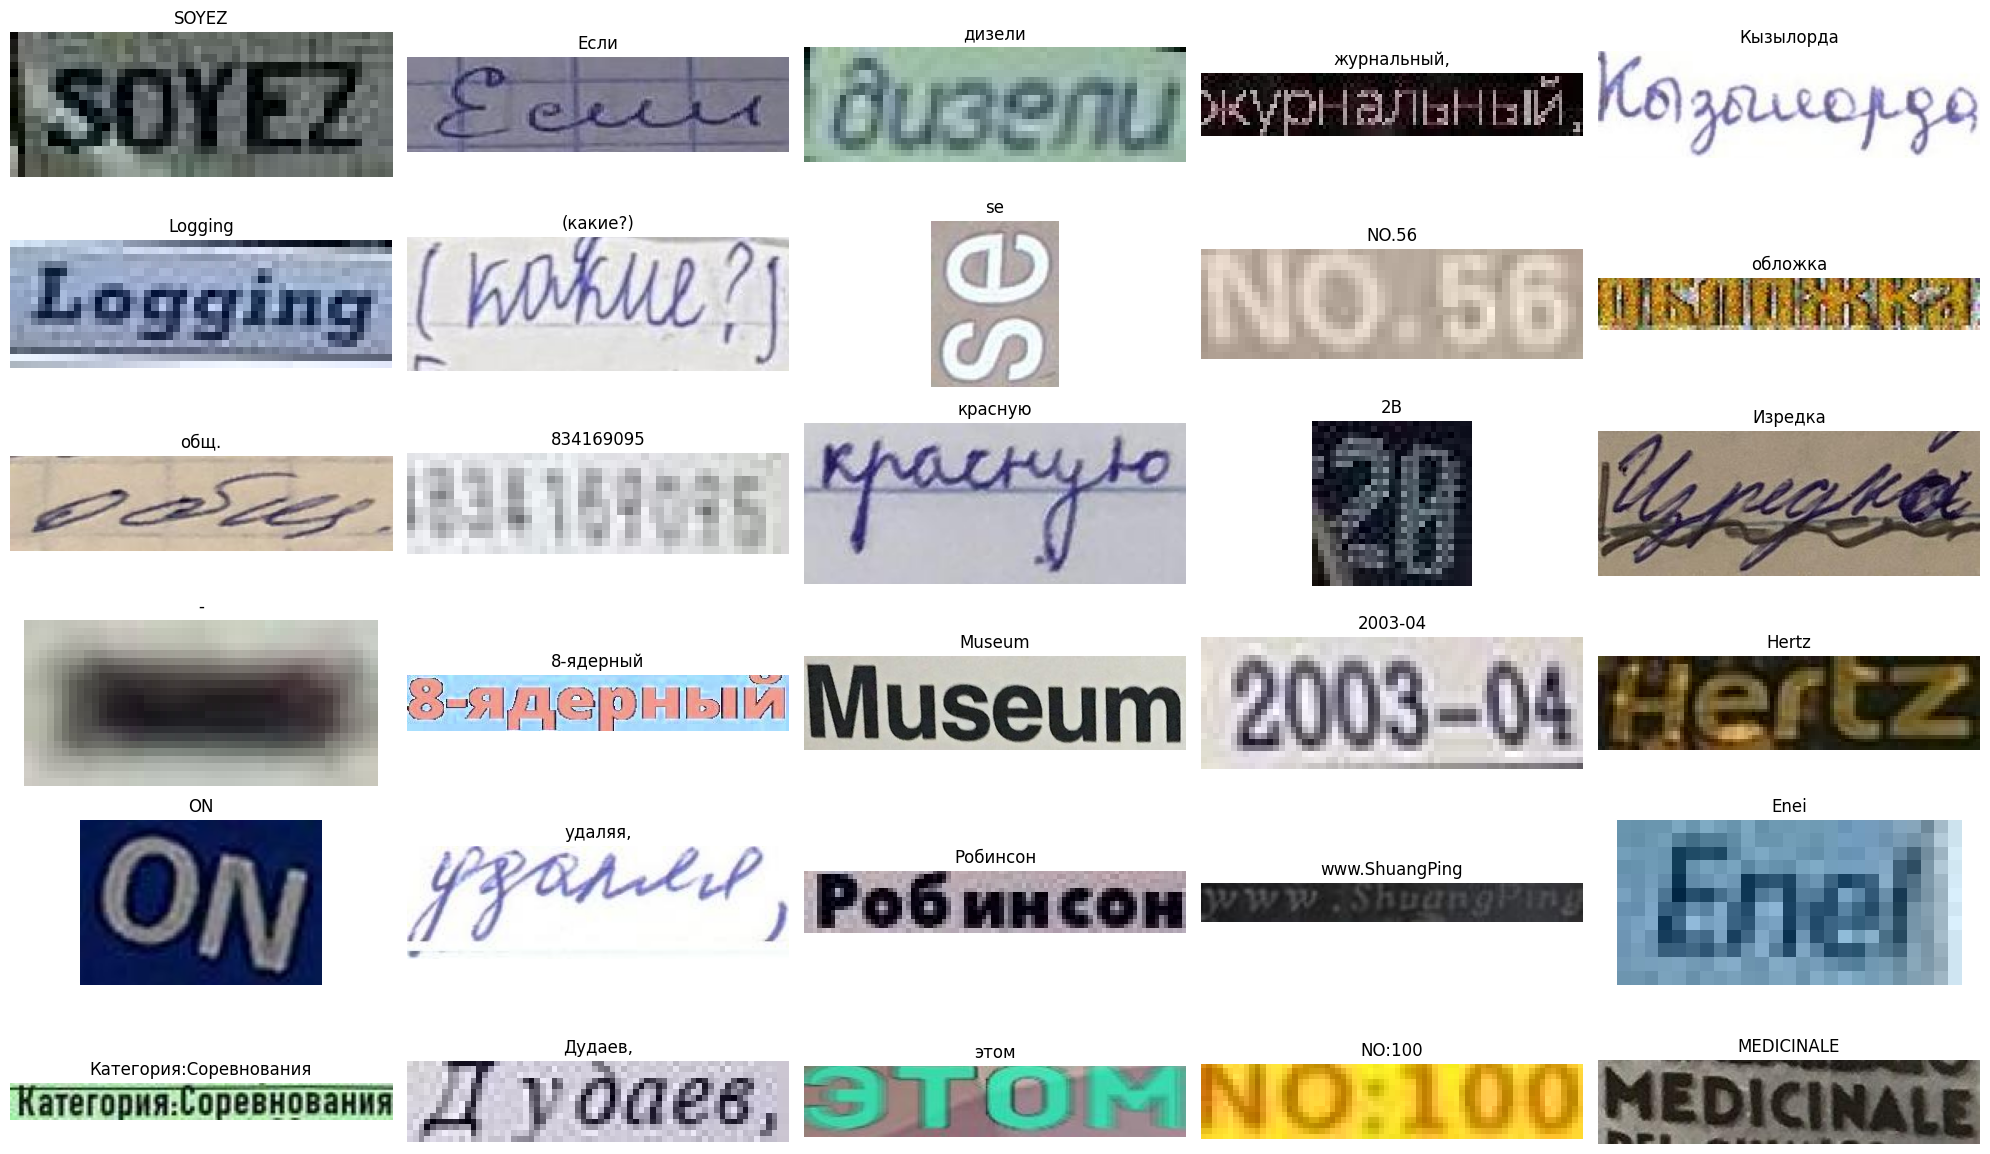

In [44]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])

    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [45]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=true_abc, transforms=transforms)

In [46]:
assert dataset[0]["image"].shape == (64, 320, 3)

Image shape: (64, 320, 3)
Seq: [28, 26, 21] Seq_len: 3
Text: рой


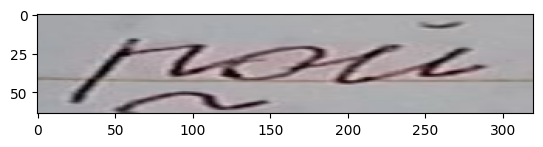

In [47]:
x = dataset[11]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

In [48]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [49]:
xs = [dataset[i] for i in range(5)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [50]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([5, 3, 64, 320])
Seq: torch.Size([27])
Seq: tensor([44, 30, 39, 28, 11, 31, 30, 28, 11, 25, 19, 33, 26, 15, 43, 30, 26, 37,
        31, 37, 16, 25, 20, 21, 88,  8,  5], dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9, 2], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,', '74']


### 3. Построение модели

In [51]:
class FeatureExtractor(Module):

    def __init__(self, input_size=(64, 320), output_len=MAX_SEQ_LEN):
        super(FeatureExtractor, self).__init__()

        h, w = input_size
        resnet = getattr(models, 'resnet34')(weights="ResNet34_Weights.IMAGENET1K_V1")
        self.cnn = Sequential(*list(resnet.children())[:-2])

        self.pool = AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn2.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.

        Args:
            - x: Tensor of features (shaped B x C x H x W).

        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()

        return x

    def forward(self, x):
        features = self.cnn(x)
        features = self.pool(features)
        features = self.apply_projection(features)

        return features

In [52]:
feature_extractor = FeatureExtractor()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 47.3MB/s]


In [53]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 25)

In [54]:
class SequencePredictor(Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2, bidirectional=False):
        super(SequencePredictor, self).__init__()

        self.num_classes = num_classes
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)

        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)

    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.

        Args:
            - batch_size: Int size of batch

        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1

        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)

        return h

    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.

        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).

        Returns:
            New tensor shaped (W x B x H).
        """

        x = x.squeeze(1)
        x = x.permute(2, 0, 1)

        return x

    def forward(self, x):
        x = self._reshape_features(x)

        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)

        x = self.fc(x)
        return x

In [55]:
sequence_predictor = SequencePredictor(input_size=512,
                                       hidden_size=128,
                                       num_layers=2,
                                       num_classes=len(true_abc) + 1)

In [56]:
x = torch.randn(1, 1, 512, 25)
y = sequence_predictor(x)
assert y.size() == (25, 1, 162)

In [57]:
class CRNN(Module):

    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=MAX_SEQ_LEN,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.2, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(true_abc)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [58]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out


def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [60]:
crnn = CRNN()

In [61]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (25, 1, 162)

In [62]:
decode(y, true_abc)

['sГL;/sPгPq;`угFJANюNVN']

In [64]:
torch.tensor([dataset[0]["image"]]).permute(0, 3, 1, 2).shape

torch.Size([1, 3, 64, 320])

In [65]:
y = crnn(torch.tensor([dataset[2]["image"]]).permute(0, 3, 1, 2))

In [66]:
decode(y, true_abc)

['ЖqМhсыd;ыNыqГqN']

In [67]:
dataset[2]["text"]

'ходят'

### 4. Обучение модели

In [68]:
num_epochs = 8
batch_size = 64

In [69]:
# if torch.has_mps:
#     device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [70]:
device

device(type='cuda')

In [71]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, true_abc, transforms=Resize(size=(320, 64)))
val_dataset = RecognitionDataset(config_val, true_abc, transforms=Resize(size=(320, 64)))

In [72]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True, pin_memory=True,
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size, shuffle=False, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn)

In [75]:
model = CRNN()
model.to(device);

In [76]:
criterion = nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

plotlosses = PlotLosses()

min_cer = 5.

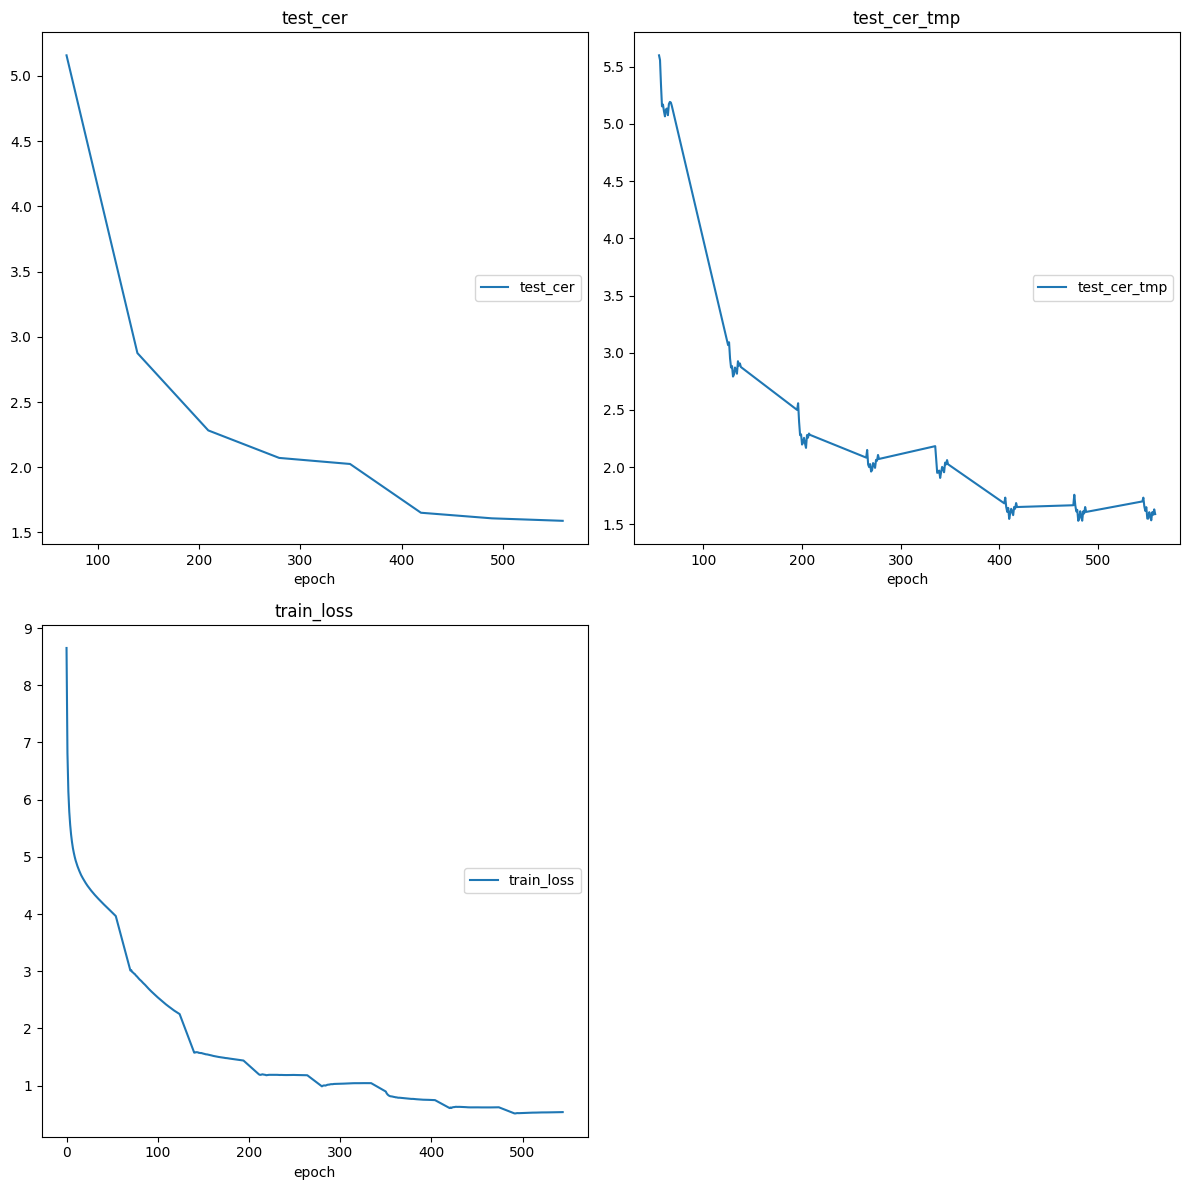

test_cer
	test_cer         	 (min:    1.589, max:    5.157, cur:    1.589)
test_cer_tmp
	test_cer_tmp     	 (min:    1.531, max:    5.600, cur:    1.589)
train_loss
	train_loss       	 (min:    0.513, max:    8.652, cur:    0.537)


In [141]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.
    for idx, b in enumerate(train_dataloader):
        # if idx > 2:
        #   break

        optimizer.zero_grad()

        input, seqs_gt = b["image"], b["seq"]
        input = input.to(device)
        seqs_gt = seqs_gt.long().to(device)
        preds = model(input).log_softmax(dim=2)
        seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()
        loss = criterion(preds, seqs_gt, seq_lens_pred, b['seq_len'])
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().item()
        if (idx + 1) % 60 == 0:
            mean_loss = running_loss / (idx + 1)
            plotlosses.update({
                'train_loss': mean_loss,
            })
            plotlosses.send()

    exp_lr_scheduler.step()
    model.eval()
    running_cer = 0.
    for idx, b in enumerate(val_dataloader):
        # if idx > 101:
        #     break
        input, text = b["image"], b["text"]

        input = input.to(device)
        preds = model(input).cpu().detach()
        texts_pred = decode(preds, true_abc)

        for pred, target in zip(texts_pred, text):
            cer = lev.distance(pred, target)
        running_cer += cer

        if (idx + 1) % 60 == 0:
            mean_cer_tmp = running_cer / (idx + 1)
            plotlosses.update({
                'test_cer_tmp': mean_cer_tmp,
            })
            plotlosses.send()

    mean_cer = running_cer / len(val_dataloader)
    if mean_cer < min_cer:
        torch.save(model.state_dict(), "/content/drive/My Drive/cv_hw_2/best_ocr.pth")
        min_cer = mean_cer
    plotlosses.update({
        'test_cer': mean_cer,
    })
    plotlosses.send()


In [142]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

In [143]:
save_checkpoint('/content/drive/My Drive/cv_hw_2/checkpoints/model_8', model, optimizer)

model saved to /content/drive/My Drive/cv_hw_2/checkpoints/model_8


In [144]:
test_data = TestDataset(PATH_TO_DATA, true_abc, (320, 64))

In [145]:
def collate_fn_2(batch):
    images, names = [], []
    for item in batch:
        image, name = item[0], item[1]
        images.append(torch.from_numpy(image).permute(2, 0, 1).float())
        names.append(name)
    images = torch.stack(images)
    batch = (images, names)
    return batch

In [146]:
test_dataloader = DataLoader(test_data,
                            batch_size=batch_size, shuffle=False, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn_2)

In [147]:
def generate_submission(test_dataloader, model, name, device_name):
    idxs = []
    decoded_preds = []
    model.eval()
    for idx, batch in enumerate(tqdm(test_dataloader)):
        # if idx > 3:
        #     break
        x, image_id = batch
        x = x.to(device_name)
        idxs += image_id
        seqs_pred = model(x).cpu().detach()
        decoded_preds += decode(seqs_pred, true_abc)

    data = {"Id": idxs, "Predicted": decoded_preds}
    res = pd.DataFrame(data)
    res.to_csv('/content/drive/My Drive/cv_hw_2/submissions/' + name, index=False)
    return res

In [148]:
res = generate_submission(test_dataloader, model, "8_ep.csv", device)

100%|██████████| 829/829 [01:28<00:00,  9.40it/s]


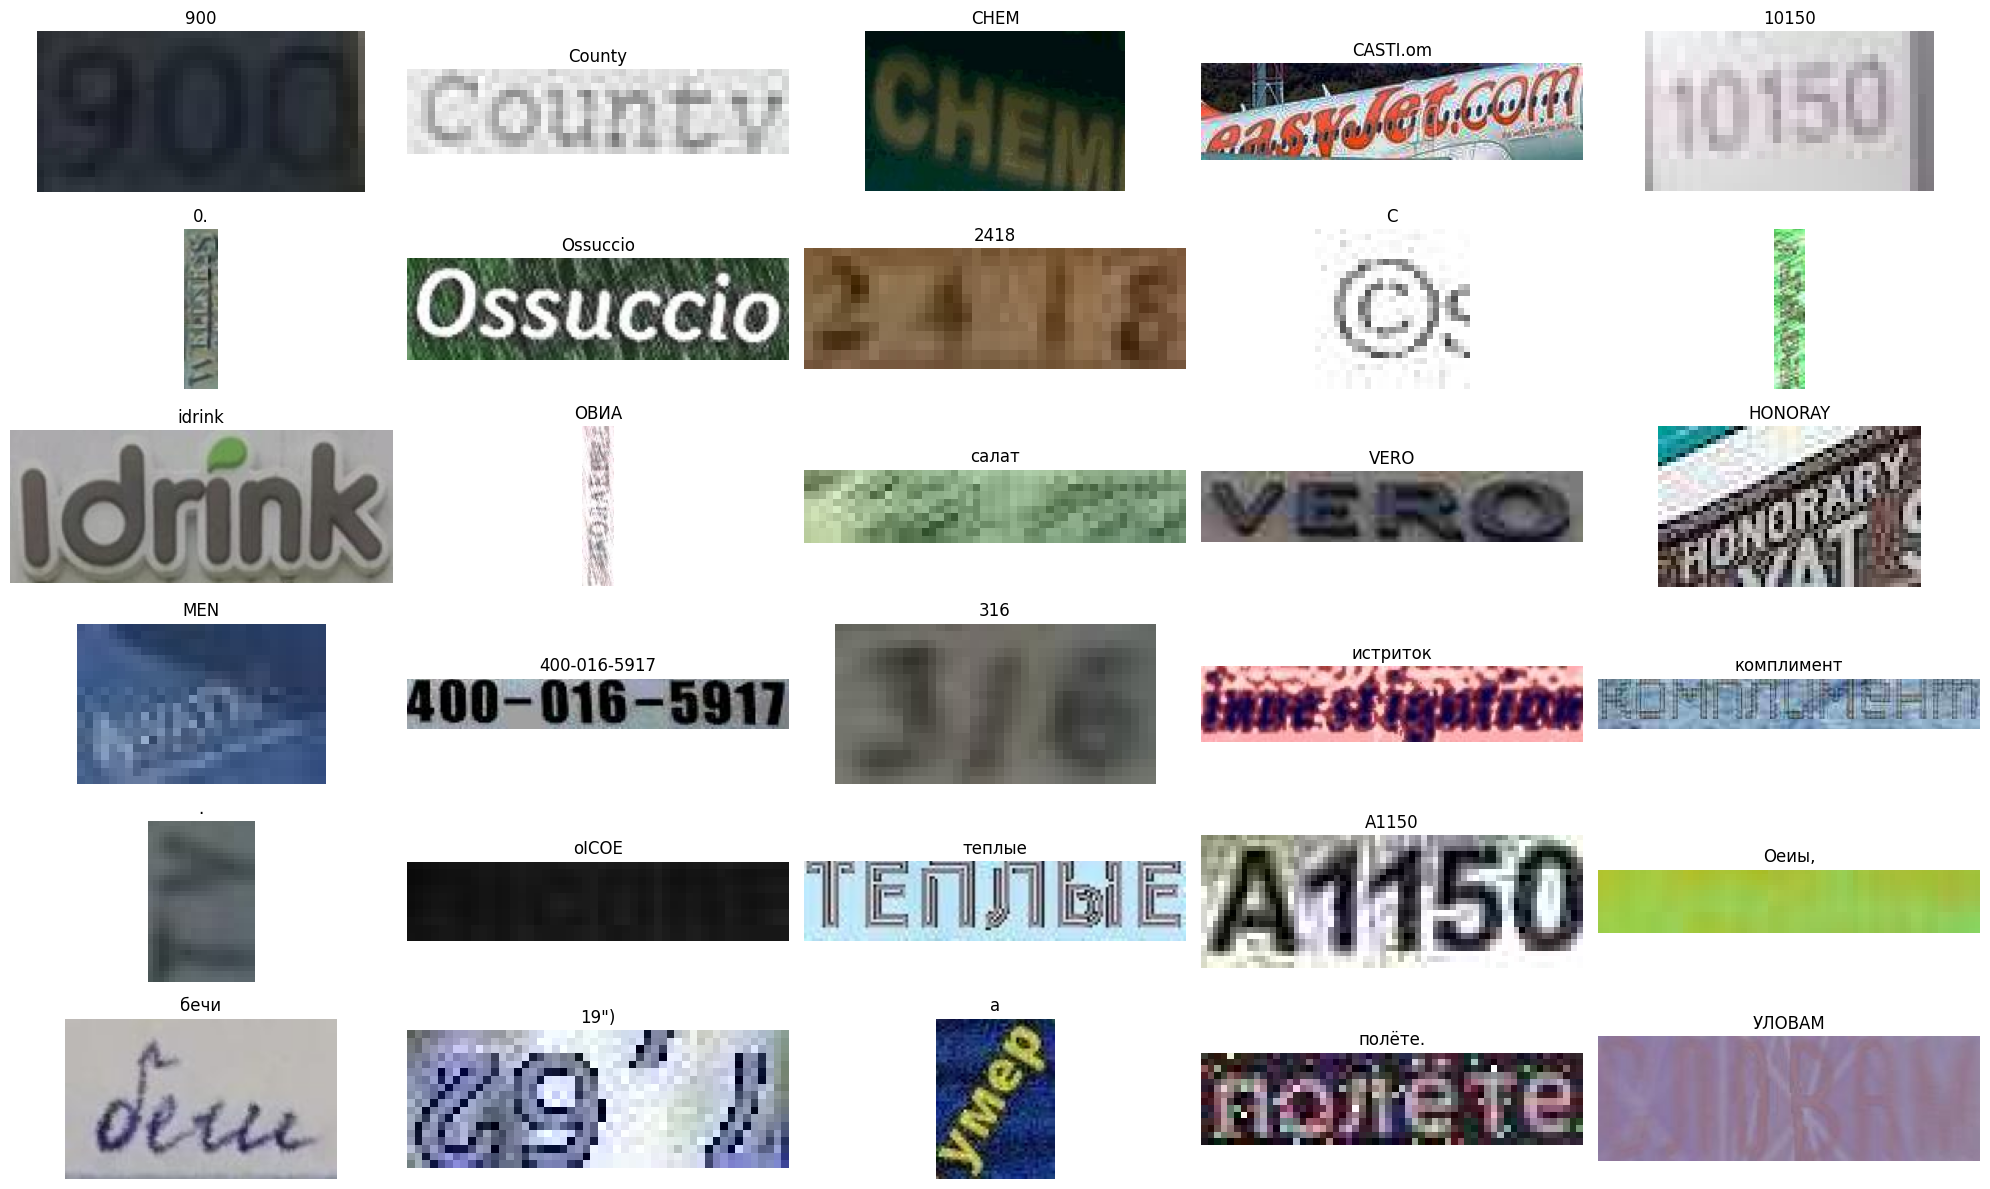

In [150]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(test_data), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    _, image_id = test_data[idx]
    text = res[res["Id"] == image_id].values.tolist()[0][1]

    image = cv2.imread(PATH_TO_DATA +  "test/test/" + image_id)

    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")

plt.tight_layout()
plt.show()